### Modelling sulfide saturation and melt Cu in the deep crust as a function of ƒO<sub>2</sub>

This Jupyter Notebook shows a minimum working example for the models presented in Nathwani et al. (in revision). The notebook uses outputs from MAGEMin (Riel et al. 2021) and functions from PySulfSat (Wieser and Gleeson 2023)


In [67]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import math as math
import PySulfSat as ss
import matplotlib as mpl
import periodictable as pt
import seaborn as sb
import sulfur as sf
import matplotlib as mpl


Cycle through each MAGEMin generated liquid line of descent and calculate SCSS, S speciation and melt Cu concentrations

In [69]:
data = pd.read_csv('../data/LLDs_blatter.csv')

data['MnO_liq_mage'] = 0
data['P2O5_liq_mage'] = 0

data.iloc[:, 6:] = data.iloc[:, 6:]*100 # convert to wt%

# Delete problematic data with low melt fraction
data = data.drop(data[data.melt_frac_wt < 0.1].index)

# Model setup
n_llds = len(data['simulation'].unique()) # Number of LLDs in dataframe
s_initial = np.random.uniform(1000,3000,n_llds) # initial sulfur in the melt (ppm) range (s_min, s_max, n)
Cu_initial = np.random.uniform(50,100,n_llds) # initial Cu from MORB range given in Lee et al. 2012
DCu_minmelt = 0.1 # partition coefficient for Cu mineral/melt
Ag_initial = np.random.uniform(0.02,0.03,n_llds) # initial Ag from Jenner et al.
DAg_minmelt = 0.1 # partition coefficient for Cu mineral/melt
Au_initial = np.random.uniform(0.002,0.004,n_llds) # initial Au guesstimated
DAu_minmelt = 0.1 # partition coefficient for Cu mineral/melt
rho_mss = 4610 # density of pyrrhotite
Fe_FeNiCu_Sulf = 0.75    # Approximate the sulfide composition 

mss_sl_ratio = np.zeros(n_llds) # MSS/SL ratio
sulfide_liquidus = 1130
sulfide_solidus = 1080

llds = [data.groupby('simulation').get_group(x) for x in data.groupby('simulation').groups]

outputs = []
n = 0
for lld in llds:

    # Calculate the ratio of MSS to SL. At higher T, SL is favoured. Use the phase diagram of sulfide liquid from Bockrath et al. (2004) to approximate ratio with temperature 1130
    lld['mss_sl_ratio'] = np.where(lld['T_C'] > sulfide_liquidus, 0, 1.0) # 100% SL above liquidus
    rel_t = lld['T_C'] - sulfide_solidus  # relative temperature between solidus and liquidus'
    lld['mss_sl_ratio']  = np.where((lld['T_C'] < sulfide_liquidus) & (lld['T_C'] > sulfide_solidus), -0.02*rel_t+1, lld['mss_sl_ratio']) # Where below liquidus and solidus, interpolate between 100% SL and 100% MSS

    lld['S_melt'] = s_initial[n] * (lld['abs_melt_frac']/100)**(0-1) # Assuming sulfur is completely incompatible estimate its % increase in the melt

    # New dataframe compatibly with ss
    data_scss = lld[['SiO2_liq_mage', 'TiO2_liq_mage', 'Al2O3_liq_mage', 'FeO_liq_mage', 'MgO_liq_mage', 'CaO_liq_mage', 'Na2O_liq_mage', 'MnO_liq_mage', 'P2O5_liq_mage', 'K2O_liq_mage', 'H2O_liq_mage']]
    data_scss.columns = ['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'CaO_Liq', 'Na2O_Liq', 'MnO_Liq','P2O5_Liq', 'K2O_Liq', 'H2O_Liq']

    # Li & Zhang SCSS
    LZ2022_SCSS = ss.calculate_LiZhang2022_SCSS(df=data_scss,T_K=lld['T_C']+273.15, P_kbar=lld['P_kbar'], Fe_FeNiCu_Sulf=Fe_FeNiCu_Sulf, logfo2=sf.calc_logfo2(lld['T_C'], lld['delta_QFM']))
    lld['SCSS_Tot'] = LZ2022_SCSS['SCSS_Tot']

    # O'Neill and Mavrogenes S6+/Stotal
    lld['S6_total'] = sf.S6_total_OandM(composition=data_scss, T_C = lld['T_C'], del_FMQ=lld['delta_QFM'])

    # Convert bulk sulfur in melt to S2- in the melt
    lld['S2_melt'] = lld['S_melt']*(1-lld['S6_total'])

    # Sulfate content at sulfate saturation Zajacz & Tsay (2019)
    ZT2019_SCAS = ss.calculate_ZT2019_SCAS(df=data_scss, T_K=lld['T_C']+273.15)
    lld['S6_melt'] = lld['S_melt']*lld['S6_total']
    sulfate_saturated = np.where(lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm'], 'Saturated', 'Undersaturated')

    # Now we calcualte the S melt, which will be buffered by SCSS or SCAS if it sulfide or sulfate saturated
    # if sulfide saturated and not sulfate saturated
    lld['S_melt'] = np.where((lld['SCSS_Tot'] < lld['S2_melt']) & (lld['S6_melt'] < ZT2019_SCAS['SCAS6_ppm']), lld['SCSS_Tot'], lld['S_melt'])
    
    # if sulfate saturated and not sulfide saturated
    lld['S_melt'] = np.where((lld['SCSS_Tot'] > lld['S2_melt']) & (lld['S6_melt'] > ZT2019_SCAS['SCAS6_ppm']), ZT2019_SCAS['SCAS6_ppm'], lld['S_melt'])
    lld['Andyrite before Sulfide'] = np.where((lld['SCSS_Tot'] > lld['S2_melt']) & (lld['S6_melt'] > ZT2019_SCAS['SCAS6_ppm']), 1, 0)
    
    # if both sulfide and sulfate saturated, take the sulfur content which is lowest 
    lld['S_melt'] = np.where((lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm']) & (lld['SCSS_Tot'] > lld['S2_melt']) & (ZT2019_SCAS['SCAS6_ppm'] < lld['SCSS_Tot']),
                              ZT2019_SCAS['SCAS6_ppm'], lld['S_melt'])
    lld['S_melt'] = np.where((lld['S6_melt']>ZT2019_SCAS['SCAS6_ppm']) & (lld['SCSS_Tot'] > lld['S2_melt']) & (ZT2019_SCAS['SCAS6_ppm'] > lld['SCSS_Tot']),
                              lld['SCSS_Tot'], lld['S_melt'])
    

    lld['mass_mss'] = (s_initial[n] * 1-lld['SCSS_Tot'] * lld['abs_melt_frac']/100)/10**6  *  pt.formula("FeS").mass/pt.formula("S").mass

    bool =  np.where(lld['SCSS_Tot'] > lld['S2_melt'], 0, 1)
    lld['mass_mss'] = bool*lld['mass_mss'] # boolean if sulphide is saturated
    lld['cum_mass_mss'] = np.cumsum(lld['mass_mss'])
    lld['vol_mss_sol'] = (lld['mass_mss']*100)/(rho_mss/lld['density_solid'])
    lld['vol_mss_liq'] = (lld['mass_mss']*100)/(rho_mss/lld['density_liquid'])
    lld['cum_vol_mss_sol'] = np.cumsum(lld['vol_mss_sol'])
    
    # Calculate MSS/melt partition coefficients
    DCu_MSS = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Cu', sulfur_phase = 'MSS')
    DAu_MSS = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Au', sulfur_phase = 'MSS')
    DAg_MSS = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Ag', sulfur_phase = 'MSS')

    # Calculate SL/melt partition coefficients (sulfide liquid)
    DCu_SL = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Cu', sulfur_phase = 'SL')
    DAu_SL = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Au', sulfur_phase = 'SL')
    DAg_SL = sf.calc_D(T = lld['T_C']+273.15, del_FMQ = lld['delta_QFM'], FeOmelt = lld['FeO_liq_mage'], element = 'Ag', sulfur_phase = 'SL')

    lld['mss_sl_ratio'] = lld['mss_sl_ratio']*bool # Only when sulfide is saturated

    # Calculate bulk partition coefficients for MSS and SL
    DCu_S = (DCu_MSS * lld['mss_sl_ratio']) + (DCu_SL * (1 - lld['mss_sl_ratio']))
    DAu_S = (DAu_MSS * lld['mss_sl_ratio']) + (DAu_SL * (1 - lld['mss_sl_ratio']))
    DAg_S = (DAg_MSS * lld['mss_sl_ratio']) + (DAg_SL * (1 - lld['mss_sl_ratio']))

    # Calculate bulk partition coefficient
    D_Cu = DCu_minmelt * (100 - lld['abs_melt_frac']) / 100 + DCu_S * lld['mass_mss']
    D_Au = DAu_minmelt * (100 - lld['abs_melt_frac']) / 100 + DAu_S * lld['mass_mss']
    D_Ag = DAg_minmelt * (100 - lld['abs_melt_frac']) / 100 + DAg_S * lld['mass_mss']
    
    # Calculate melt composition using Rayliegh FC
    lld['Cu_melt'] = sf.calc_melt_comp(Cu_initial[n], D_Cu, lld['abs_melt_frac'], 'FC')
    lld['Au_melt'] = sf.calc_melt_comp(Au_initial[n], D_Au, lld['abs_melt_frac'], 'FC')
    lld['Ag_melt'] = sf.calc_melt_comp(Ag_initial[n], D_Ag, lld['abs_melt_frac'], 'FC')

    outputs.append(lld)
    n = n + 1
data_sulf = pd.concat(outputs, axis=0, ignore_index=True)

Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
replacing Fe3Fet_Liq in the original dataframe with that input into the function
Using inputted Fe_FeNiCu_Sulf ratio for calculations.
r

Post-process the data to check for the conditions when sulfide saturates – e.g. at what melt fraction does sulfide saturate in the different models

In [70]:
data_sulf['Mg#_sol'] = ((1/40.32)*data_sulf['MgO_sol_mage'])/(((0.9/79.8)*data_sulf['FeO_sol_mage'])+((1/40.32)*data_sulf['MgO_sol_mage']))
data_sulf['Mg#_liq'] = ((1/40.32)*data_sulf['MgO_liq_mage'])/(((0.9/79.8)*data_sulf['FeO_liq_mage'])+((1/40.32)*data_sulf['MgO_liq_mage']))


llds = [data_sulf.groupby('simulation').get_group(x) for x in data_sulf.groupby('simulation').groups]

ss_mg = np.zeros(len(llds)) # Empty list of Mg# at sulfide saturation
ss_mgsol = np.zeros(len(llds)) # Empty list of Mg# of solid at sulfide saturation
dqfm = np.zeros(len(llds))
ss_sio2 = np.zeros(len(llds))
ss_melt_frac = np.zeros(len(llds))
ss_T = np.zeros(len(llds)) # Empty list of T at sulfide saturation
sa_mg = np.zeros(len(llds)) # Empty list of Mg# at sulfide saturation
sa_mgsol = np.zeros(len(llds)) # Empty list of Mg# of solid at anhydrite saturation
sa_sio2 = np.zeros(len(llds))
sa_melt_frac = np.zeros(len(llds))
sa_T = np.zeros(len(llds)) # Empty list of T at anhydrite saturation
P = np.zeros(len(llds)) # Empty list of P

n = 0
for lld in llds:
    
    lld = lld.reset_index(drop=True)
    # Store the point at which sulfide saturates 
    bool =  np.where(lld['SCSS_Tot'] > lld['S2_melt'], 0, 1)
    if 1 in bool:
        ss_index = list(bool).index(1)
        ss_mg[n] = lld['Mg#_liq'].iloc[ss_index]
        ss_mgsol[n] = lld['Mg#_sol'].iloc[ss_index]
        ss_sio2[n] = lld['SiO2_liq_mage'].iloc[ss_index]
        ss_melt_frac[n] = lld['abs_melt_frac'].iloc[ss_index]
        ss_T[n] = lld['T_C'].iloc[ss_index]
    else:
        ss_index = 'Undersaturated'
        ss_mg[n] = np.nan # If you never saturate in sulfide use 0
        ss_mgsol[n] = np.nan
        ss_sio2[n] = np.nan # If you never saturate in sulfide use 0
        ss_melt_frac[n] = np.nan
        ss_T[n] = np.nan
    dqfm[n] = lld['delta_QFM'].iloc[0]
    P[n] = lld['P_kbar'].iloc[0]

    # Store the point at which anydrite saturates
    bool2 =  lld['Andyrite before Sulfide']
    if 1 in bool2.values:
        sa_index = list(bool2.astype(int)).index(1)
        sa_mg[n] = lld['Mg#_liq'].iloc[sa_index]
        sa_mgsol[n] = lld['Mg#_sol'].iloc[sa_index]
        sa_sio2[n] = lld['SiO2_liq_mage'].iloc[sa_index]
        sa_melt_frac[n] = lld['abs_melt_frac'].iloc[sa_index]
        sa_T[n] = lld['T_C'].iloc[sa_index]

    else:
        sa_index = 'Undersaturated'
        sa_mg[n] = np.nan # If you never saturate in sulfide use 0
        sa_mgsol[n] = np.nan
        sa_sio2[n] = np.nan # If you never saturate in sulfide use 0
        sa_melt_frac[n] = np.nan 
        sa_T[n] = np.nan
        
    n = n + 1

ss_df = pd.concat([pd.Series(dqfm, name = 'dQFM'), pd.Series(ss_sio2, name = 'SiO2 at SS'), pd.Series(ss_mg, name = '#Mg Liq at SS'),
                   pd.Series(s_initial, name = "Initial S"), pd.Series(ss_melt_frac, name = 'Melt Fraction'), pd.Series(ss_T, name = 'Temperature'), pd.Series(P, name = 'P (kbar)')], axis = 1)

sa_df = pd.concat([pd.Series(dqfm, name = 'dQFM'), pd.Series(sa_sio2, name = 'SiO2 at SS'), 
                   pd.Series(s_initial, name = "Initial S"), pd.Series(sa_melt_frac, name = 'Melt Fraction'), pd.Series(sa_T, name = 'Temperature'), pd.Series(P, name = 'P (kbar)')], axis = 1)

# ss_df = ss_df.dropna()
# sa_df = sa_df.dropna()

Import arc whole-rock data for comparison with models

In [71]:
# Whole rock Cu data for arcs

lt_df = pd.read_csv('../data/Lee_Tang_Appendix.csv') # Lee and Tang (2020) compilation of arc whole-rock data
lt_df = lt_df[lt_df['Cu'].notna()]

# Create 4% bins for SiO2
bin_edges = np.arange(45, 75+2, 2)  # Define bin edges
lt_df['SiO2_bins'] = pd.cut(lt_df['SiO2'], bins=bin_edges)

# Group by bins and calculate the average Cu values
binned_data_mean = lt_df.groupby('SiO2_bins')['Cu'].mean().reset_index()
binned_data_lq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.05).reset_index()
binned_data_uq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.95).reset_index()
binned_data = lt_df.groupby('SiO2_bins').size().reset_index(name='counts')

# Extract bin labels and averages
bin_labels = binned_data['SiO2_bins'].astype(str)  # Bin ranges as strings
average_cu_all = binned_data_mean['Cu']

x = (bin_edges+1)[:-1]

/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_21691/4241910069.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data_mean = lt_df.groupby('SiO2_bins')['Cu'].mean().reset_index()
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_21691/4241910069.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data_lq = lt_df.groupby('SiO2_bins')['Cu'].quantile(0.05).reset_index()
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_21691/4241910069.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

Generate Figure 4 of the paper

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:48: SyntaxWarning: invalid escape sequence '\S'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:48: SyntaxWarning: invalid escape sequence '\S'
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_21691/1182665421.py:12: SyntaxWarning: invalid escape sequence '\D'
  axs[0].set_xlabel('$\Delta$FMQ')
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_21691/1182665421.py:32: SyntaxWarning: invalid escape sequence '\D'
  axs[1].figure.colorbar(sm, label = '$\Delta$FMQ', ax = axs[1])
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_21691/1182665421.py:48: SyntaxWarning: invalid escape sequence '\S'
  axs[0].annotate(xy = (1.4, 40), text = '\nApatite\nS$^{6+}/\Sigma{}$S', color = 'gray', horizontalalignment = 'center')
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_21691/1182665421.py:51: UserWarn

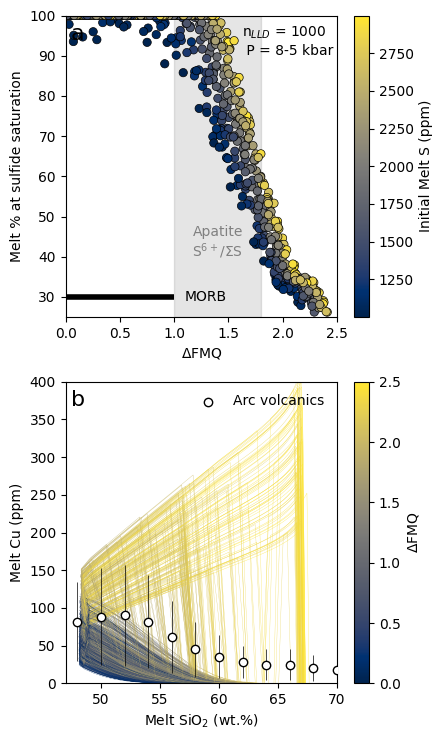

In [92]:
from matplotlib import colors
from matplotlib import cm
norm = colors.Normalize(vmin=s_initial.min(), vmax=s_initial.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.cividis)
cmap.set_array([])

fig, axs = plt.subplots(2,1, figsize = (4.5,7.5))

axs[0].axvspan(1.4-0.4, 1.4+0.4, color="black", alpha=0.1)

sb.scatterplot(x=ss_df['dQFM'], y=ss_df['Melt Fraction'], edgecolor = 'black', c  = cmap.to_rgba(ss_df["Initial S"]), ax = axs[0])
axs[0].set_xlabel('$\Delta$FMQ')
axs[0].set_ylabel('Melt % at sulfide saturation')

norm = plt.Normalize(s_initial.min(), s_initial.max())
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])

axs[0].figure.colorbar(sm, label = 'Initial Melt S (ppm)', ax = axs[0])

# Color scale
norm = mpl.colors.Normalize(vmin=data['delta_QFM'].min(), vmax=data['delta_QFM'].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)
cmap.set_array([])

for lld in llds:
    axs[1].plot(lld['SiO2_liq_mage'], lld['Cu_melt'], color = cmap.to_rgba(lld['delta_QFM'].iloc[0]), linewidth = 0.2)

norm = plt.Normalize(vmin=round(data['delta_QFM'].min(),1), vmax=round(data['delta_QFM'].max(),1))
sm = plt.cm.ScalarMappable(cmap="cividis", norm=norm)
sm.set_array([])
axs[1].figure.colorbar(sm, label = '$\Delta$FMQ', ax = axs[1])

axs[1].set_ylabel('Melt Cu (ppm)')
axs[1].set_xlabel('Melt SiO$_{2}$ (wt.%)')

axs[1].set_ylim([0, 400])
axs[0].set_ylim([25,100])
axs[0].set_xlim([0.0, 2.5])
axs[1].set_xlim([47,70])

axs[0].hlines(24, 0.6, 1.9, color = 'black', linewidth = 4)
axs[0].hlines(30, 0, 1.0, color = 'black', linewidth = 4)

axs[0].annotate(xy = (1.1, 29), text = 'MORB', color = 'black')
axs[0].annotate(xy = (2.0, 23), text = 'Arc', color = 'black')

axs[0].annotate(xy = (1.4, 40), text = '\nApatite\nS$^{6+}/\Sigma{}$S', color = 'gray', horizontalalignment = 'center')

axs[1].annotate(xy = (1.4, 5), text = 'Arc', color = 'black')
axs[1].legend(loc = 2, framealpha = 0)


axs[1].errorbar(x= x, y = average_cu_all, yerr = average_cu_all-binned_data_lq['Cu'], zorder = 100,color = 'black', linewidth = 0.5, ls = 'none')
axs[1].scatter(x, average_cu_all, zorder = 100, color = 'white', edgecolor = 'black', label = 'Arc volcanics')

axs[0].annotate(xy = (0.02, 0.92), text = 'a', fontsize = 16, xycoords = 'axes fraction')
axs[1].annotate(xy = (0.02, 0.92), text = 'b', fontsize = 16, xycoords = 'axes fraction')


axs[0].annotate(xy = (0.65,0.87), text = 'n$_{LLD}$ = %1d \n P = %1d-%1d kbar' % (len(llds), round(data['P_kbar'].max()), round(data['P_kbar'].min())), xycoords = 'axes fraction')

axs[1].legend(loc = 'upper right', framealpha = 0)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('../outputs/SiO2_at_SS.png', dpi = 1200)
plt.show()